## Cats and Dogs Classification

by Elena Eleftheriou and Antreas Laos

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim as optim 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

device

'cpu'

Load Data

In [2]:
#data augmentation
transform = transforms.Compose([
    transforms.Resize((128, 128)),               
    transforms.RandomHorizontalFlip(p=0.5),      
    transforms.ToTensor()                        
])

train_dataset = datasets.ImageFolder(root='catdog_data/train', transform=transform)
test_dataset = datasets.ImageFolder(root='catdog_data/test', transform=transform)
validation_dataset = datasets.ImageFolder(root='catdog_data/validation', transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=64, shuffle=False)

Print some examples in train dataset

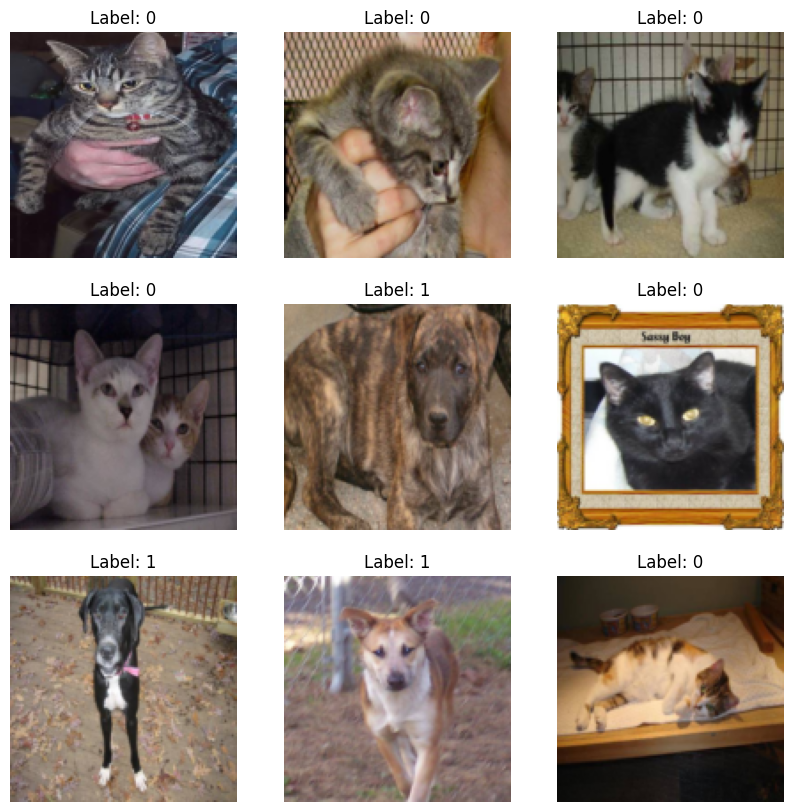

In [3]:
sample_images, sample_labels = next(iter(train_loader))  
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i].permute(1, 2, 0)) 
    plt.title(f'Label: {sample_labels[i]}')
    plt.axis('off')
plt.show()

Model

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)       # 3 input channels (RGB), 32 output channels
        self.conv2 = nn.Conv2d(32, 64, 3, 1)      # 64 output channels
        self.pool = nn.MaxPool2d(2, 2)            # Max pooling layer with 2x2 kernel
        self.dropout = nn.Dropout(0.25)           # Dropout layer with 25% dropout rate

        self.fc1 = nn.Linear(64 * 30 * 30, 128)   
        self.fc2 = nn.Linear(128, 2)              # 2 output nodes for binary classification

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, 64 * 30 * 30)
        x = torch.relu(self.fc1(x))               
        x = self.dropout(x)                       # Apply dropout for regularization
        x = self.fc2(x)                           # Output layer

        return x

model = SimpleCNN()


Train loop and validation

In [5]:
def validation(criterion):
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    correct = 0
    with torch.no_grad():  # Disable gradient calculation
        for images, labels in validation_loader:
            output = model(images)
            loss = criterion(output, labels)
            val_loss += loss.item()
            
            # Calculate accuracy
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max logit
            correct += pred.eq(labels.view_as(pred)).sum().item()
    val_loss /= len(validation_loader)
    return 100. * correct / len(validation_dataset)
    

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.train()
for epoch in range(50):
    running_loss = 0.0
    for img, label in train_loader:
        optimizer.zero_grad()
        outputs = model(img)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    val_accuracy = validation(criterion)

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}, Validation Accuracy: {val_accuracy:.2f}%")


Epoch 1, Loss: 0.30031821550801396, Validation Accuracy: 70.00%
Epoch 2, Loss: 0.2142358897253871, Validation Accuracy: 68.83%
Epoch 3, Loss: 0.17323150346055627, Validation Accuracy: 69.67%
Epoch 4, Loss: 0.14981592469848692, Validation Accuracy: 67.00%
Epoch 5, Loss: 0.1221964715514332, Validation Accuracy: 69.17%
Epoch 6, Loss: 0.08765893965028226, Validation Accuracy: 68.33%
Epoch 7, Loss: 0.08556644094642252, Validation Accuracy: 68.17%
Epoch 8, Loss: 0.05568932491587475, Validation Accuracy: 71.33%
Epoch 9, Loss: 0.05672484351089224, Validation Accuracy: 67.67%
Epoch 10, Loss: 0.05537230905611068, Validation Accuracy: 70.00%
Epoch 11, Loss: 0.03814704388787504, Validation Accuracy: 69.67%
Epoch 12, Loss: 0.019139979835017584, Validation Accuracy: 69.33%
Epoch 13, Loss: 0.016127371141919866, Validation Accuracy: 68.67%
Epoch 14, Loss: 0.012565731463837437, Validation Accuracy: 69.33%
Epoch 15, Loss: 0.012659723695833236, Validation Accuracy: 68.83%
Epoch 16, Loss: 0.03175219518016

KeyboardInterrupt: 

Evaluate the model

In [9]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for img, label in test_loader:
        outputs = model(img)
        _, predicted = torch.max(outputs.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy}%")

Test Accuracy: 72.0%
